In [ ]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')
Path='drive/My Drive'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv(Path+'/septic_patients_data_alone.csv')

In [ ]:
df['SepsisLabel'].value_counts()


0    144494
1     27916
Name: SepsisLabel, dtype: int64

In [ ]:
Neg_Cases=144494
pos_cases=27916
scale_pos_weight=Neg_Cases/pos_cases
scale_pos_weight

5.176028084252758

In [ ]:
#df=df.drop(columns=['EtCO2', 'Bilirubin_direct','TroponinI','Fibrinogen','sepsisType','Unit1','Unit2'])
#df=df.drop(columns=['sepsisType'])
       

# **Imputing** **the Null's using Interpolation**

In [ ]:
PIdArray=df['Patient_ID'].unique()
df_output=pd.DataFrame()
for i in PIdArray:
    df_new=df[df['Patient_ID']==i].interpolate(limit_direction='both')
    df_output=df_output.append(df_new)

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
#clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
x = df_output.drop(['sepsisType','SepsisLabel'], axis=1) # assigning features to x, y
y = df_output['SepsisLabel']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
xgb_cl = xgb.XGBClassifier(objective='binary:logistic',n_estimator=6,seed=42)
xgb_cl.fit(x_train, y_train)
preds = xgb_cl.predict(x_val)
accuracy = accuracy_score(y_val, preds)
accuracy

0.8527927614407517

# Estimating the value for the scale_pos_weight XGBoost hyperparameter **bold text**



In [ ]:
#model = XGBClassifier(scale_pos_weight=5.176)
from collections import Counter
# generate dataset
#X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
#	n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=7)
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 5.176


# Model's performance using repeated k-fold cross-validation.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
model = XGBClassifier(scale_pos_weight=5.176)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.81153


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
#xgb_cl = xgb.XGBClassifier(objective='binary:logistic',n_estimator=6,seed=42)
model.fit(x_train, y_train)
preds = model.predict(x_val)
accuracy = accuracy_score(y_val, preds)
accuracy

0.7740850298706572

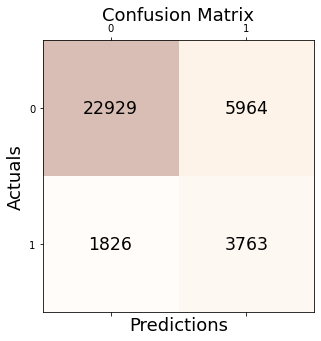

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, preds)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

True Positive (TP) = 3763; meaning 3763 positive class data points were correctly classified by the model

True Negative (TN) = 22929; meaning 22929 negative class data points were correctly classified by the model

False Positive (FP) = 5964; meaning 5964 negative class data points were incorrectly classified as belonging to the positive class by the model

False Negative (FN) = 1826; meaning 1826 positive class data points were incorrectly classified as belonging to the negative class by the model

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#tp, fn, fp, tn = confusion_matrix(y_val, preds)
tp, fn, fp, tn = confusion_matrix(y_val, preds,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)
print("------------------")

print('Recall: %.2f' % recall_score(y_val, preds))
print("------------------")
print('Precision: %.2f' % precision_score(y_val, preds))
print("------------------")
print('F1 Score: %.2f' % f1_score(y_val, preds))
#f1_score(y_val, preds, average='weighted') 

#classification report for precision, recall f1-score and accuracy
#matrix = classification_report(y_val, preds,labels=[1,0])
#print('Classification report : \n',matrix)

Outcome values : 
 3763 1826 5964 22929
------------------
Recall: 0.67
------------------
Precision: 0.39
------------------
F1 Score: 0.49


# Tune the Class Weighting Hyperparameter

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
weights = [1, 2,3,4,5,7,10]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(x, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("========================")
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811370 using {'scale_pos_weight': 5}
0.804639 (0.003242) with: {'scale_pos_weight': 1}
0.808186 (0.003783) with: {'scale_pos_weight': 2}
0.810030 (0.003920) with: {'scale_pos_weight': 3}
0.810287 (0.003769) with: {'scale_pos_weight': 4}
0.811370 (0.003901) with: {'scale_pos_weight': 5}
0.811041 (0.003825) with: {'scale_pos_weight': 7}
0.810099 (0.003874) with: {'scale_pos_weight': 10}


# Metrices result before applying stratified k fold & weighted parameter

# **Confusion matrix** 


In [ ]:
#clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
x = df_output.drop(['sepsisType','SepsisLabel'], axis=1) # assigning features to x, y
y = df_output['SepsisLabel']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
xgb_cl = xgb.XGBClassifier(objective='binary:logistic',n_estimator=6,seed=42)
xgb_cl.fit(x_train, y_train)
preds = xgb_cl.predict(x_val)
accuracy = accuracy_score(y_val, preds)
accuracy

0.8527927614407517

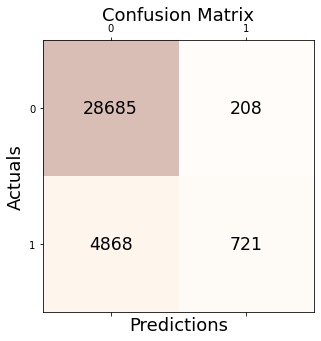

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, preds)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

True Positive (TP) = 721; meaning 721 positive class data points were correctly classified by the model

True Negative (TN) = 28685; meaning 28685 negative class data points were correctly classified by the model

False Positive (FP) = 208; meaning 208 negative class data points were incorrectly classified as belonging to the positive class by the model

False Negative (FN) = 4868; meaning 4868 positive class data points were incorrectly classified as belonging to the negative class by the model


# Recall , Precision, F1 Score 

*   Precision :

Precision tells us how many of the correctly predicted cases actually turned out to be positive.

Model precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made. 
The precision score is a useful measure of the success of prediction when the classes are very imbalanced. Mathematically,
 it represents the ratio of true positive to the sum of true positive and false positive.

Precision Score = TP / (FP + TP)

For example, machine learning models are used in medical diagnosis applications 
where the doctor wants machine learning models that will not provide a label of pneumonia if the patient does not have this disease. 
Oncologists ideally want models that can identify all cancerous lesions without any false-positive results, 
and hence one could use a precision score in such cases. 
Note that a greater number of false positives will result in a lot of stress for the patients in general although that may not turn
out to be fatal from a health perspective.
 Further tests will be able to negate the false positive prediction.

* Model **recall** score represents the model’s ability to correctly predict the positives out of actual positives. 
* **F1 Score ** : It is termed as a harmonic mean of Precision and Recall and it can give us better metrics of incorrectly classified classes than the Accuracy Metric.

It can be a better measure to use if we need to seek a balance between Precision and Recall





In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#tp, fn, fp, tn = confusion_matrix(y_val, preds)
tp, fn, fp, tn = confusion_matrix(y_val, preds,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)
print("------------------")

print('Recall: %.2f' % recall_score(y_val, preds))
print("------------------")
print('Precision: %.2f' % precision_score(y_val, preds))
print("------------------")
print('F1 Score: %.2f' % f1_score(y_val, preds))
#f1_score(y_val, preds, average='weighted') 

#classification report for precision, recall f1-score and accuracy
#matrix = classification_report(y_val, preds,labels=[1,0])
#print('Classification report : \n',matrix)

Outcome values : 
 721 4868 208 28685
------------------
Recall: 0.13
------------------
Precision: 0.78
------------------
F1 Score: 0.22


In [ ]:
# Verifing
Recall=tp/(tp+fn)
Recall

0.1290033995348005

#Classification report for precision, recall f1-score and accuracy

In [ ]:
#classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
matrix = classification_report(y_val, preds,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.78      0.13      0.22      5589
           0       0.85      0.99      0.92     28893

    accuracy                           0.85     34482
   macro avg       0.82      0.56      0.57     34482
weighted avg       0.84      0.85      0.81     34482



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb_cl, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.80464


#  AUC - ROC Curve

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.
The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis **bold text**.

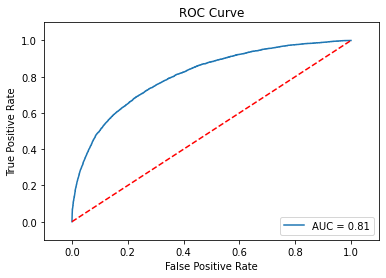

In [ ]:
from sklearn import metrics
#use model to predict probability that given y value is 1
y_preds = xgb_cl.predict_proba(x_val)
# take the second column because the classifier outputs scores for
# the 0 class as well
predss = y_preds[:,1]

#ns_probs = [0 for _ in range(len(testy))]
#ns_auc = roc_auc_score(testy, ns_probs)
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
#pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

#calculate AUC of model
auc = metrics.roc_auc_score(y_val, predss)

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_val, predss)

#auc_score = metrics.auc(fpr, tpr)

# clear current figure
#plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))

plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

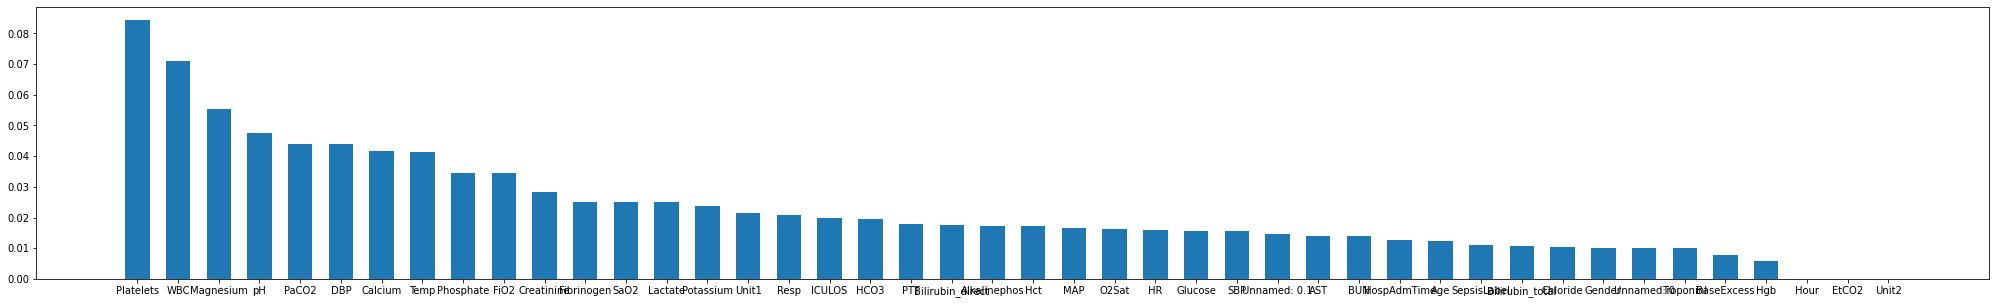

In [ ]:
import matplotlib.pyplot as plt
importance_data = sorted(list(zip(df_output.columns,xgb_cl.feature_importances_)),key=lambda tpl:tpl[1],reverse=True)

xs = range(len(importance_data))
labels = [x for (x,_) in importance_data]
ys = [y for (_,y) in importance_data]

# plot
#plt.xgb_cl()
#fig = plt.figure()
fig = plt.figure()

fig.set_figheight(5)
fig.set_figwidth(35)

plt.bar(xs,ys,width=0.6)
plt.xticks(xs,labels)
plt.show()

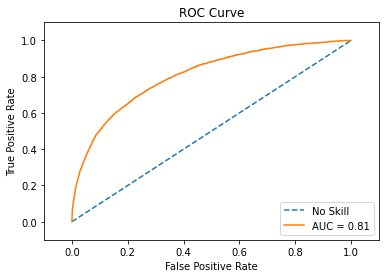

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
#use model to predict probability that given y value is 1
y_preds = xgb_cl.predict_proba(x_val)
# take the second column because the classifier outputs scores for
# the 0 class as well
predss = y_preds[:,1]

ns_probs = [0 for _ in range(len(y_val))]
ns_auc = roc_auc_score(y_val, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
#pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

#calculate AUC of model
auc = metrics.roc_auc_score(y_val, predss)

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_val, predss)

#auc_score = metrics.auc(fpr, tpr)

# clear current figure
#plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))

#plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

So our model's AUC is 0.81, it means there is a 81% chance that the model will be able to distinguish between positive class and negative class.

Analysis 

-->Our model, XGBoost's ability to distinguish between positive class and negative class is 81%

-->Model’s ability to correctly predict the positives out of actual positives is not good.

--> This model correctly predict the positives out of all the positive predictions